# Imports

In [ ]:
from google.colab import drive
import os
import glob
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.image import flip_left_right, random_brightness, random_contrast
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Bidirectional, Input
 )
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical

from PIL import Image
from tqdm import tqdm

# Dataset Loading & Cleaning
This cell mounts Google Drive, loads the SAMM2 Excel sheet, cleans the header rows, drops incomplete records, and shows a quick preview of the data frame.

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to your SAMM2 CSV
csv_path = "/content/drive/MyDrive/SAMM2 labeled/SAMM_Micro_FACS_Codes_v2.xlsx"

# Load and clean the data
df = pd.read_excel(csv_path, header=12)
df.columns = df.iloc[0]
df = df[1:]
df = df.dropna(subset=["Subject", "Filename", "Onset Frame", "Offset Frame", "Estimated Emotion"])

# Show example
df.head()


Mounted at /content/drive


,Subject,Filename,Inducement Code,Onset Frame,Apex Frame,Offset Frame,Duration,Micro,Action Units,Estimated Emotion,Objective Classes,Notes
1,006,006_1_2,1,5562,5588,5632,71,Micro - 1/2,4+7,Anger,3,NaN
2,006,006_1_3,1,3912,3948,3988,77,Micro - 1/2,4,Anger,3,While blinking
3,006,006_1_4,1,2324,2368,2403,80,Micro - 1/2,4+7,Anger,3,NaN
4,006,006_1_5,1,5343,5388,5424,82,Micro - 1/2,4+7,Anger,3,NaN
5,006,006_1_6,1,7160,7197,7259,100,Micro - 1/2,4+7+43,Anger,7,Double AU4


# Frame Loading Utilities
Defines image loading helpers, including flexible filename matching, grayscale resizing, normalization, and sequence assembly for each onset–offset range.

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BASE_DATASET_PATH = "/content/drive/MyDrive/SAMM2 labeled"

def find_image_path(folder_path, subject, frame_number):
    """
    Tries to find an image file with the given subject and frame number
    using flexible zero-padding matching.
    """
    possible_patterns = [
        f"{subject}_{frame_number}.jpg",
        f"{subject}_0{frame_number}.jpg",
        f"{subject}_{frame_number:04d}.jpg",
        f"{subject}_{frame_number:05d}.jpg",
        f"{subject}_{str(frame_number).zfill(5)}.jpg",
    ]

    for pattern in possible_patterns:
        full_path = os.path.join(folder_path, pattern)
        if os.path.exists(full_path):
            return full_path

    # Fallback: fuzzy match using glob
    matches = glob.glob(os.path.join(folder_path, f"{subject}_*{frame_number}.jpg"))
    if matches:
        return matches[0]

    return None

def load_frame_sequence(subject, filename, onset_frame, offset_frame):
    folder_path = os.path.join(BASE_DATASET_PATH, str(subject), filename)
    frames = []

    for frame in range(onset_frame, offset_frame + 1):
        img_path = find_image_path(folder_path, subject, frame)
        if img_path and os.path.exists(img_path):
            img = Image.open(img_path).convert("L").resize((IMG_WIDTH, IMG_HEIGHT))
            img_array = np.array(img, dtype=np.float32) / 255.0
            frames.append(img_array)
        else:
            print(f"❌ Missing frame: {subject}/{filename}/{frame}")
            return None  # Skip entire sample if any frame is missing

    # Shape = (sequence_length, height, width, 1)
    sequence = np.stack(frames, axis=0)[..., np.newaxis]
    return sequence


# Build Sequences, Pad, and Encode Labels
Iterates through annotations to build frame sequences, pads/truncates them to a fixed length, and encodes emotion labels into one-hot vectors.

In [ ]:
X_sequences = []
y_labels = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    subject = str(row["Subject"]).zfill(3)  # Ensure subject is zero-padded like "006"
    filename = row["Filename"]
    onset = int(row["Onset Frame"])
    offset = int(row["Offset Frame"])
    label = row["Estimated Emotion"]

    sequence = load_frame_sequence(subject, filename, onset, offset)

    if sequence is not None:
        X_sequences.append(sequence)
        y_labels.append(label)

# Step 1: Choose max sequence length
MAX_FRAMES = 60
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Step 2: Define padding function
def pad_sequence(seq, maxlen=MAX_FRAMES):
    seq_len = seq.shape[0]
    if seq_len >= maxlen:
        return seq[:maxlen]  # truncate
    else:
        padding = np.zeros((maxlen - seq_len, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
        return np.concatenate([seq, padding], axis=0)

# Step 3: Apply padding to all sequences
X_sequences_padded = [pad_sequence(seq, MAX_FRAMES) for seq in X_sequences]
X_sequences_padded = np.array(X_sequences_padded, dtype=np.float32)

print("✅ X_sequences_padded shape:", X_sequences_padded.shape)  # (num_samples, 60, 224, 224, 1)

# Step 4: Encode and one-hot encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_cat = to_categorical(y_encoded)

print("✅ y_cat shape:", y_cat.shape)  # (num_samples, num_classes)
print("✅ Classes:", label_encoder.classes_)



100%|██████████| 159/159 [42:55<00:00, 16.20s/it]


✅ X_sequences_padded shape: (159, 60, 224, 224, 1)
✅ y_cat shape: (159, 8)
✅ Classes: ['Anger' 'Contempt' 'Disgust' 'Fear' 'Happiness' 'Other' 'Sadness'
 'Surprise']


# Visual Sanity Check on a Sample
Reloads a sample sequence from disk and visualizes the first few frames to validate correct image loading.

✅ Loaded sequence shape: (71, 224, 224, 1)


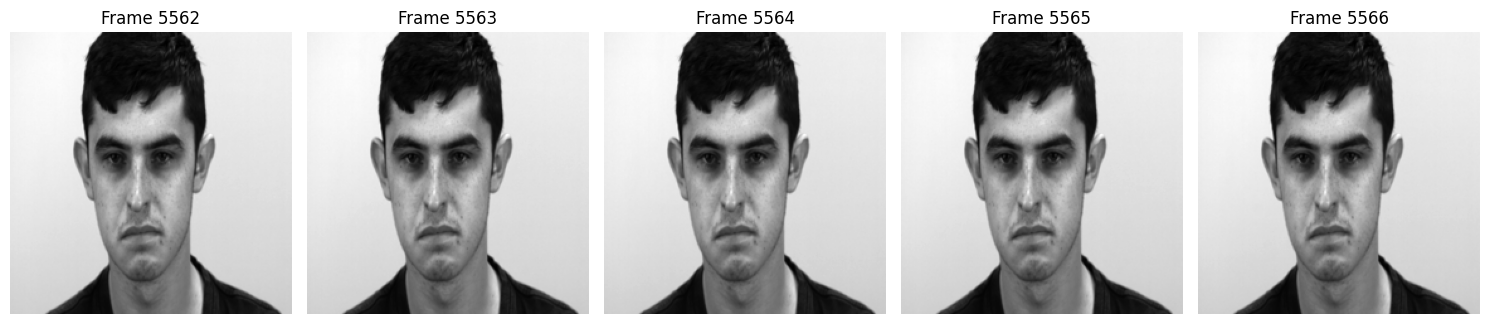

In [ ]:
# Load the CSV again just to make sure it's fresh
csv_path = "/content/drive/MyDrive/SAMM2 labeled/SAMM_Micro_FACS_Codes_v2.xlsx"
df = pd.read_excel(csv_path, header=12)
df.columns = df.iloc[0]
df = df[1:]
df = df.dropna(subset=["Filename", "Estimated Emotion"])

# Pick a row
row = df.iloc[0]
subject = str(row["Subject"]).zfill(3)  # Ensure subject is 3 digits like '006'
filename = row["Filename"]
onset = int(row["Onset Frame"])
offset = int(row["Offset Frame"])

# Load the frame sequence
sequence = load_frame_sequence(subject, filename, onset, offset)

# Display result
if sequence is not None:
    print("✅ Loaded sequence shape:", sequence.shape)

    # Show the first 5 frames
    fig, axs = plt.subplots(1, min(5, sequence.shape[0]), figsize=(15, 4))
    for i in range(min(5, sequence.shape[0])):
        axs[i].imshow(sequence[i, ..., 0], cmap='gray')
        axs[i].set_title(f"Frame {onset + i}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

else:
    print("❌ Failed to load sequence.")


# Exploratory Plots
Plots class distribution and sequence length distribution to understand dataset balance and temporal variability.

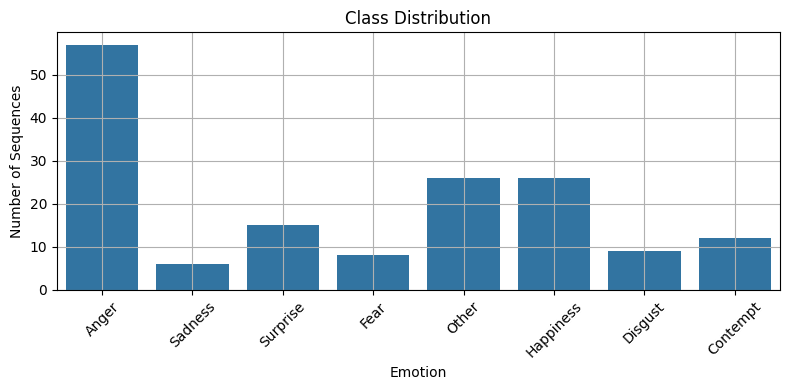

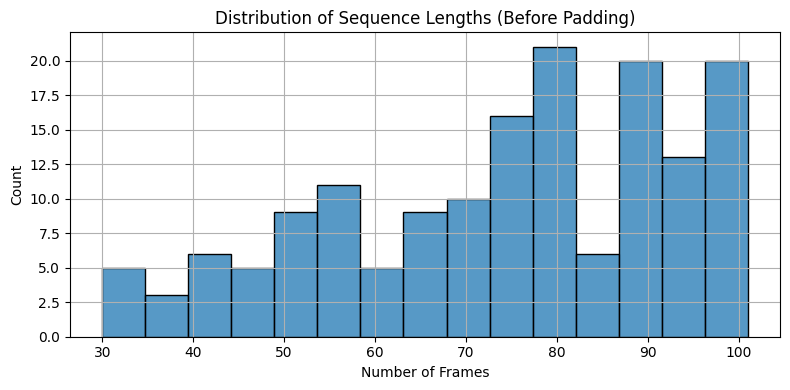

In [ ]:
# 1. Plot class distribution
label_counts = Counter(y_labels)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Class Distribution")
plt.ylabel("Number of Sequences")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Plot actual (unpadded) sequence lengths
sequence_lengths = [seq.shape[0] for seq in X_sequences]  # use your actual list name
plt.figure(figsize=(8, 4))
sns.histplot(sequence_lengths, bins=15, kde=False)
plt.title("Distribution of Sequence Lengths (Before Padding)")
plt.xlabel("Number of Frames")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()



# Class Balancing via Augmentation
Applies random frame-level augmentations to underrepresented classes, then merges augmented samples with the original dataset.

In [ ]:
# Step 1: Encode original labels properly
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_cat = to_categorical(y_encoded)

print("✅ Original Shapes:")
print("X_sequences_padded:", X_sequences_padded.shape)
print("y_cat:", y_cat.shape)

# Step 2: Augmentation function for one frame
def augment_frame(frame):
    frame = tf.convert_to_tensor(frame, dtype=tf.float32)
    if random.random() < 0.3:
        frame = flip_left_right(frame)
    if random.random() < 0.3:
        frame = random_brightness(frame, max_delta=0.1)
    if random.random() < 0.3:
        frame = random_contrast(frame, lower=0.9, upper=1.1)
    return tf.clip_by_value(frame, 0.0, 1.0)

# Step 3: Analyze class balance
label_counts = Counter(y_labels)
max_count = max(label_counts.values())

print("\n📊 Class Distribution Before Augmentation:")
for cls, count in label_counts.items():
    print(f"{cls}: {count}")

# Step 4: Augment underrepresented classes
X_augmented = []
y_augmented = []

for cls in label_encoder.classes_:
    class_indices = [i for i, label in enumerate(y_labels) if label == cls]
    current_count = len(class_indices)
    needed = max_count - current_count

    print(f"🔄 Augmenting {cls}: need {needed} more samples")

    for _ in range(needed):
        idx = random.choice(class_indices)
        sequence = X_sequences_padded[idx]  # shape: (60, 224, 224, 1)

        augmented_frames = []
        for frame in sequence:
            aug = augment_frame(frame).numpy()  # (224, 224, 1)
            augmented_frames.append(aug)

        augmented_seq = np.stack(augmented_frames, axis=0)  # (60, 224, 224, 1)
        X_augmented.append(augmented_seq)
        y_augmented.append(cls)

# Step 5: Final conversion to arrays
X_augmented = np.stack(X_augmented, axis=0)
y_augmented_encoded = label_encoder.transform(y_augmented)
y_augmented_cat = to_categorical(y_augmented_encoded)

# Step 6: Combine original + augmented
X_sequences_padded = np.concatenate([X_sequences_padded, X_augmented], axis=0)
y_cat = np.concatenate([y_cat, y_augmented_cat], axis=0)

print("\n✅ Final Shapes After Fixing:")
print("X_sequences_padded:", X_sequences_padded.shape)
print("y_cat:", y_cat.shape)


✅ Original Shapes:
X_sequences_padded: (159, 60, 224, 224, 1)
y_cat: (159, 8)

📊 Class Distribution Before Augmentation:
Anger: 57
Sadness: 6
Surprise: 15
Fear: 8
Other: 26
Happiness: 26
Disgust: 9
Contempt: 12
🔄 Augmenting Anger: need 0 more samples
🔄 Augmenting Contempt: need 45 more samples
🔄 Augmenting Disgust: need 48 more samples
🔄 Augmenting Fear: need 49 more samples
🔄 Augmenting Happiness: need 31 more samples
🔄 Augmenting Other: need 31 more samples
🔄 Augmenting Sadness: need 51 more samples
🔄 Augmenting Surprise: need 42 more samples

✅ Final Shapes After Fixing:
X_sequences_padded: (456, 60, 224, 224, 1)
y_cat: (456, 8)


# Train/Validation/Test Split
Splits the padded sequences into train, validation, and test sets with stratification to preserve class balance.

In [ ]:
# Step 1: First split TEST set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_sequences_padded, y_cat, test_size=0.2, random_state=42, stratify=y_cat.argmax(axis=1)
)

# Step 2: Then split VAL set (20% of remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp.argmax(axis=1)
)

# Confirm shapes
print("✅ Train:", X_train.shape)
print("✅ Val:", X_val.shape)
print("✅ Test:", X_test.shape)
print("\n🧪 Class distributions:")
print("Train:", Counter(np.argmax(y_train, axis=1)))
print("Val:  ", Counter(np.argmax(y_val, axis=1)))
print("Test: ", Counter(np.argmax(y_test, axis=1)))


✅ Train: (291, 60, 224, 224, 1)
✅ Val: (73, 60, 224, 224, 1)
✅ Test: (92, 60, 224, 224, 1)

🧪 Class distributions:
Train: Counter({np.int64(1): 37, np.int64(7): 37, np.int64(0): 37, np.int64(2): 36, np.int64(6): 36, np.int64(3): 36, np.int64(4): 36, np.int64(5): 36})
Val:   Counter({np.int64(5): 10, np.int64(0): 9, np.int64(6): 9, np.int64(4): 9, np.int64(3): 9, np.int64(7): 9, np.int64(1): 9, np.int64(2): 9})
Test:  Counter({np.int64(4): 12, np.int64(2): 12, np.int64(6): 12, np.int64(3): 12, np.int64(7): 11, np.int64(1): 11, np.int64(5): 11, np.int64(0): 11})


# CNN + BiLSTM Model Definition
Builds a time-distributed CNN for spatial feature extraction and a BiLSTM for temporal modeling, then compiles the model.

In [ ]:
# Build the CNN+BiLSTM model
model = Sequential([
    Input(shape=(60, 224, 224, 1)),
    TimeDistributed(Conv2D(32, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 60, 222, 222,   │           320 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 60, 111, 111,   │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 60, 109, 109,   │        18,496 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 60, 54, 54, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 60, 186624)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │    95,584,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,612,360 (364.73 MB)

 Trainable params: 95,612,360 (364.73 MB)

 Non-trainable params: 0 (0.00 B)

# Training Setup and Execution
Calculates class weights, configures callbacks, trains the model, and saves the best and final weights.

In [ ]:
earlystop_cb = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# Calculate class weights from training labels
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights_dict = dict(enumerate(class_weights))

# Save the best model checkpoint
checkpoint_cb = ModelCheckpoint("cnn_lstm_best_model.keras", save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=1,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_cb,earlystop_cb],
    verbose=2
)
model.save("cnn_lstm_trained_model.keras")



Epoch 1/50
291/291 - 61s - 209ms/step - accuracy: 0.1478 - loss: 2.1430 - val_accuracy: 0.1918 - val_loss: 2.0599
Epoch 2/50
291/291 - 40s - 136ms/step - accuracy: 0.2646 - loss: 1.9289 - val_accuracy: 0.4110 - val_loss: 1.7412
Epoch 3/50
291/291 - 40s - 137ms/step - accuracy: 0.5086 - loss: 1.4929 - val_accuracy: 0.5616 - val_loss: 1.4112
Epoch 4/50
291/291 - 40s - 136ms/step - accuracy: 0.6357 - loss: 1.1899 - val_accuracy: 0.6575 - val_loss: 1.2033
Epoch 5/50
291/291 - 40s - 137ms/step - accuracy: 0.7148 - loss: 0.9649 - val_accuracy: 0.6849 - val_loss: 0.9206
Epoch 6/50
291/291 - 40s - 136ms/step - accuracy: 0.7045 - loss: 0.8881 - val_accuracy: 0.7397 - val_loss: 0.9045
Epoch 7/50
291/291 - 40s - 136ms/step - accuracy: 0.7526 - loss: 0.7402 - val_accuracy: 0.7671 - val_loss: 0.7654
Epoch 8/50
291/291 - 40s - 136ms/step - accuracy: 0.8110 - loss: 0.5751 - val_accuracy: 0.7945 - val_loss: 0.6979
Epoch 9/50
291/291 - 40s - 136ms/step - accuracy: 0.8076 - loss: 0.5536 - val_accuracy: 

# Training Curves
Plots accuracy and loss over epochs to visualize learning progress and potential overfitting.

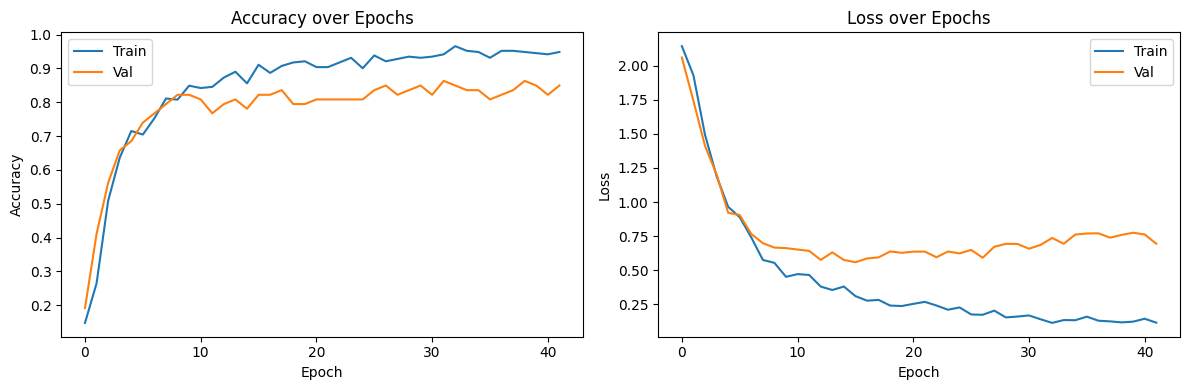

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("training_history.png")
plt.show()


# Load Trained Model
Loads the saved model from disk to verify structure and prepare for evaluation.

In [ ]:
model = load_model("cnn_lstm_trained_model.keras")
model.summary()  # should match 95M params



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 60, 222, 222,   │           320 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 60, 111, 111,   │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 60, 109, 109,   │        18,496 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 60, 54, 54, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 60, 186624)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │    95,584,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,837,082 (1.07 GB)

 Trainable params: 95,612,360 (364.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 191,224,722 (729.46 MB)

# Test Set Evaluation
Evaluates the trained model on the held-out test set and reports accuracy and loss.

In [ ]:

test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")




3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.1184 - loss: 3.2519
✅ Test Accuracy: 11.96%
✅ Test Loss: 3.2762


# Split Diagnostics
Prints class distributions for train/validation/test splits to confirm balance.

In [ ]:
print("Train:", Counter(np.argmax(y_train, axis=1)))
print("Val:  ", Counter(np.argmax(y_val, axis=1)))
print("Test: ", Counter(np.argmax(y_test, axis=1)))


Train: Counter({np.int64(1): 37, np.int64(7): 37, np.int64(0): 37, np.int64(2): 36, np.int64(6): 36, np.int64(3): 36, np.int64(4): 36, np.int64(5): 36})
Val:   Counter({np.int64(5): 10, np.int64(0): 9, np.int64(6): 9, np.int64(4): 9, np.int64(3): 9, np.int64(7): 9, np.int64(1): 9, np.int64(2): 9})
Test:  Counter({np.int64(4): 12, np.int64(2): 12, np.int64(6): 12, np.int64(3): 12, np.int64(7): 11, np.int64(1): 11, np.int64(5): 11, np.int64(0): 11})


# Confusion Matrix Analysis
Generates predictions, plots the confusion matrix, and computes manual accuracy for verification.

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


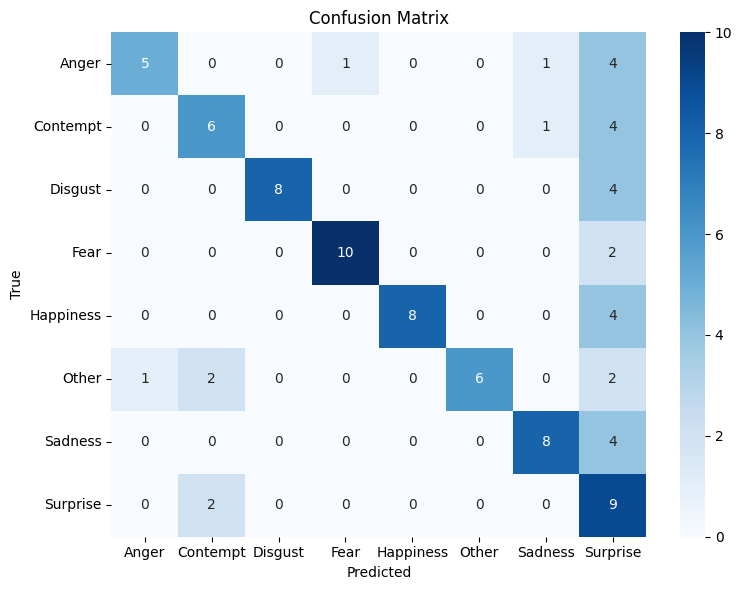

🔍 Manual Accuracy: 65.22%


In [ ]:
# Predict
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()
manual_accuracy = np.sum(y_true == y_pred_labels) / len(y_true)
print(f"🔍 Manual Accuracy: {manual_accuracy * 100:.2f}%")


# Post-Augmentation Class Balance
Plots the final class distribution after augmentation to confirm improved balance.

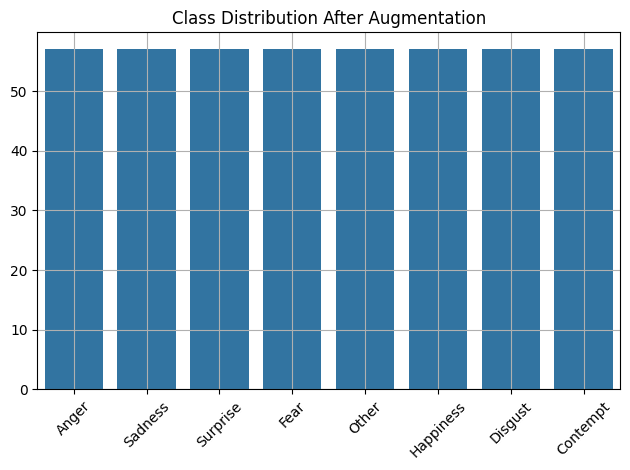

In [ ]:
# Decode to readable class names
y_labels_final = label_encoder.inverse_transform(np.argmax(y_cat, axis=1))

# Plot
final_counts = Counter(y_labels_final)
sns.barplot(x=list(final_counts.keys()), y=list(final_counts.values()))
plt.xticks(rotation=45)
plt.title("Class Distribution After Augmentation")
plt.grid(True)
plt.tight_layout()
plt.show()


# Single-Sample Inference
Runs a prediction on a single test sequence and compares the predicted emotion with the true label.

In [ ]:
# Pick a sample index (e.g. index 0)
index = 29

# Get the sequence and the true label
sample = X_test[index]           # shape: (60, 224, 224, 1)
true_label = np.argmax(y_test[index])
sample_input = np.expand_dims(sample, axis=0)  # shape becomes (1, 60, 224, 224, 1)
prediction = model.predict(sample_input)
predicted_label = np.argmax(prediction)
predicted_emotion = label_encoder.inverse_transform([predicted_label])[0]
true_emotion = label_encoder.inverse_transform([true_label])[0]

print("✅ Predicted Emotion:", predicted_emotion)
print("🎯 True Emotion:", true_emotion)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
✅ Predicted Emotion: Sadness
🎯 True Emotion: Sadness
